In [1]:
import torch
import torch.nn as nn
# import torchvision
# import torchvision.utils as utils
# import torch.optim as optim
# import torchvision.transforms as transforms
# import torchvision.datasets as datasets
import torch.nn.functional as F

import cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pickle
# from glob import glob
# import random
# import itertools
from tqdm import tqdm
from time import time

In [2]:
%cd ..

/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/HeartReconstruction


/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
img_size = 128

batch_size = 2
valid_batch_size = 2
epochs = 15
n_print = 200
lr = 0.001

workers = 2
isCuda = True
device = torch.device("cuda:0" if (torch.cuda.is_available() and isCuda) else "cpu")
torch.backends.cudnn.benchmark = True
print("Device: {}".format(device))

model_saved_dir = "results/U2Net"
if os.path.exists(model_saved_dir) == False:
    os.mkdir(model_saved_dir)

Device: cuda:0


In [4]:
from typing import List
import os

# Dataset

In [5]:
import warnings
warnings.filterwarnings('ignore')


def get_image_filepaths(main_path, img_format, as_mask=False):
    
    # Сюда всё запишем
    filepaths = []
    # Итерируемся по всем пациентам
    for address, dirs, files in os.walk(main_path):
        # Все названия внутри каждого пациента
        for name in files:
            # Выбираем нужный формат
            if img_format in name:
                # Добавляем путь до изображения или маски
                if os.path.exists(os.path.join(address, name)):
                    filepaths.append(os.path.join(address, name))

    # assert len(files) == len(filepaths), f"There're another format of files, .txt, for instance. File is: {filepaths}"
    
    return filepaths

In [6]:
format = '.png'

train_path = "data/train/train"
test_path = "data/train/test"

img_train_paths = get_image_filepaths(os.path.join(train_path, "images"), format, as_mask=False)
img_test_paths = get_image_filepaths(os.path.join(test_path, "images"), format, as_mask=False)

msk_train_paths = get_image_filepaths(os.path.join(train_path, "masks"), format, as_mask=True)
msk_test_paths = get_image_filepaths(os.path.join(test_path, "masks"), format, as_mask=True)

len(img_train_paths), len(msk_test_paths)

(3400, 600)

In [7]:
class HeartLoader(torch.utils.data.Dataset):
    def __init__(self, imgs_paths, masks_paths):
        """ Simple image torch Dataset for images and masks in photo format """
        assert len(imgs_paths) == len(masks_paths)

        assert isinstance(imgs_paths, List)
        assert isinstance(imgs_paths[0], str)
        assert os.path.exists(imgs_paths[0])

        assert isinstance(masks_paths, List)
        assert isinstance(masks_paths[0], str)
        assert os.path.exists(masks_paths[0])

        # Save
        self.imgs_paths = imgs_paths
        self.masks_paths = masks_paths
        
    def choose_mask(self, mask):
        """ We need only 1 type """
        return np.where(mask == 255, 1., 0.).astype(np.float32)
            
    def __getitem__(self, index):

        img = cv2.imread(self.imgs_paths[index])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.preprocess(img)
        # img = self.normalize(img)
        img = np.transpose(img, (2, 0, 1))

        mask = cv2.imread(self.masks_paths[index], 0)   # 0 meanks Like a grayscale
        # mask = preprocess(mask)
        mask = self.choose_mask(mask)
        # mask = self.posprocess(mask)
        mask = np.expand_dims(mask, 0)
        
        # mask = mask.squeeze(0)

        return img.astype(np.float32), mask.astype(np.float32)

    def __len__(self):
        return len(self.imgs_paths)

    def preprocess(self, data):
        # Resize or something else the same
        return data / 255

    def posprocess(self, data):
        # mask = mask.squeeze(0)
        pass


# Restore images to suitable images of opencv style
def ImgForPlot(img):
    # img = np.einsum('ijk->jki', img)
    # img = (127.5*(img+1)).astype(np.uint8)
    return np.transpose(img, (1, 2, 0))
     


In [8]:
img_train_paths[:5], msk_train_paths[:5]

(['data/train/train/images/2662.png',
  'data/train/train/images/1045.png',
  'data/train/train/images/1445.png',
  'data/train/train/images/3274.png',
  'data/train/train/images/0413.png'],
 ['data/train/train/masks/2662.png',
  'data/train/train/masks/1045.png',
  'data/train/train/masks/1445.png',
  'data/train/train/masks/3274.png',
  'data/train/train/masks/0413.png'])

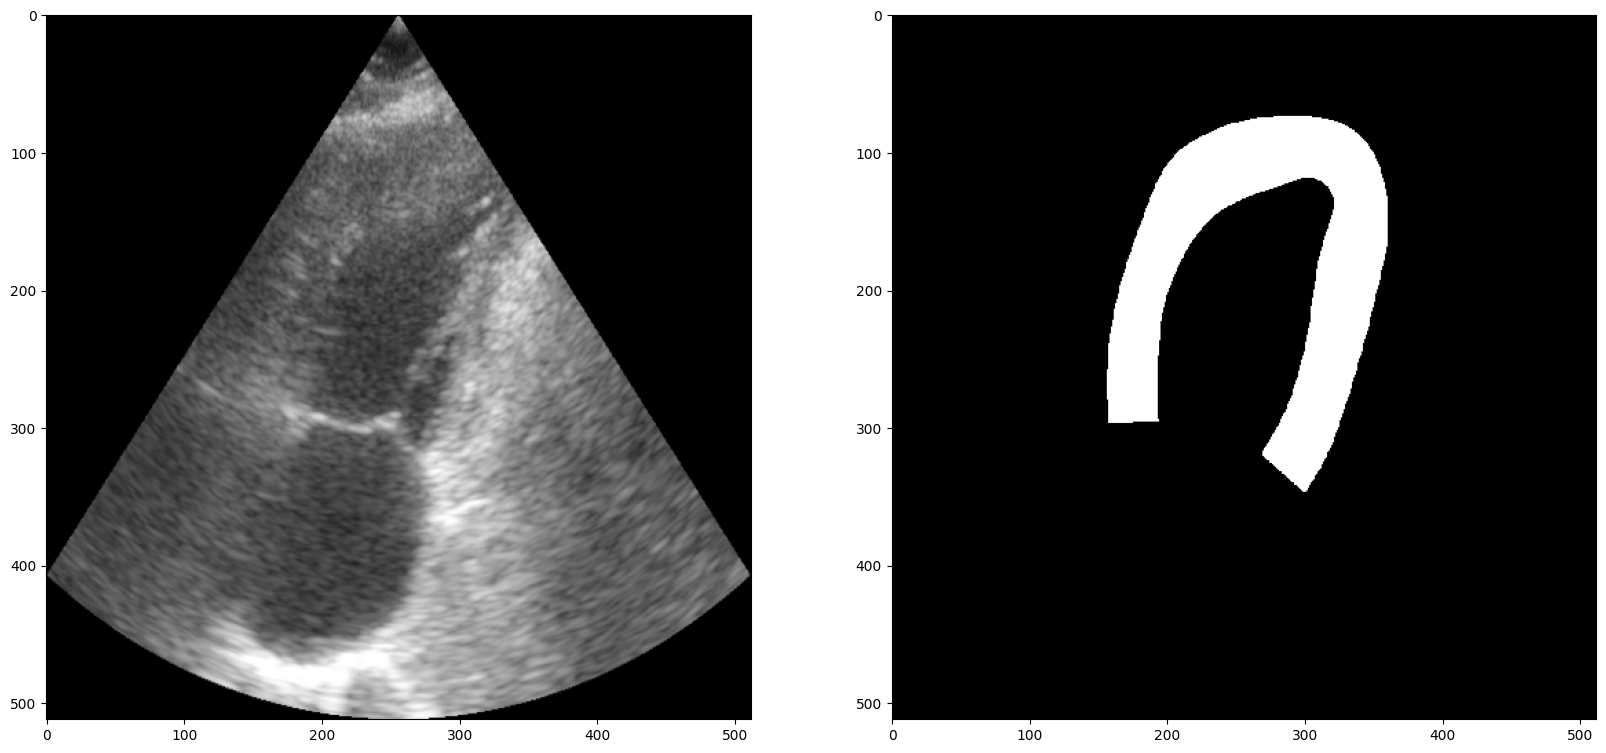

In [9]:
# transform = transforms.Compose([transforms.ToTensor(),
#                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
dataset = HeartLoader(img_train_paths, msk_train_paths)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

valid_dataset = HeartLoader(img_test_paths, msk_test_paths)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=valid_batch_size, shuffle=True, num_workers=workers)
     
im, m = dataset[777]

fig = plt.figure(figsize=(20,20))

plt.subplot(121)
plt.imshow(ImgForPlot(im));
plt.subplot(122)
plt.imshow(ImgForPlot(m), 'gray');

In [10]:
# # Test dataset
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=True, num_workers=workers)

# test_loss = 0.
# model.eval()
# with torch.no_grad():
#   for i in range(len(test_dataloader)):
#     input, target = next(iter(test_dataloader))
#     out = model(input.cuda())[-1]
#     test_loss += MAE(out, target.cuda()).item() / len(test_dataloader)

# print(test_loss)

In [11]:
# mean = torch.tensor([0.485, 0.456, 0.406])
# std = torch.tensor([0.229, 0.224, 0.225])
 
# resize_shape = (320,320)
 
# transforms = T.Compose([T.ToTensor(),
#                         T.Normalize(mean=mean, std=std)])

In [12]:
# def prepare_image_batch(image_dir, resize, transforms, device):
 
#     image_batch = []
 
#     for image_file in os.listdir(image_dir):
#         image = Image.open(os.path.join(image_dir, image_file)).convert("RGB")
#         image_resize = image.resize(resize, resample = Image.BILINEAR)
     
#         image_trans = transforms(image_resize)
#         image_batch.append(image_trans)
     
     
#     image_batch = torch.stack(image_batch).to(device)
 
#     return image_batch
 
# image_batch = prepare_image_batch(image_dir="test_images",
#                                  resize=resize_shape,
#                                  transforms=transforms,
#                                  device="cuda:0")

In [13]:
# Test

# Model

In [14]:

def init_weight(layer):
    nn.init.xavier_uniform_(layer.weight)
    if layer.bias is not None:
        nn.init.constant_(layer.bias, 0)

In [15]:
class ConvBlock(nn.Module):
  def __init__(self, in_channel, out_channel, dilation=1):
    super(ConvBlock, self).__init__()
    self.conv = nn.Conv2d(in_channel, out_channel, 3, stride=1, padding=dilation, dilation=dilation)
    self.bn = nn.BatchNorm2d(out_channel)
    self.relu = nn.ReLU(inplace = True)
    init_weight(self.conv)

  def forward(self, x):
    return self.relu(self.bn(self.conv(x)))

In [16]:
class RSU(nn.Module):
  def __init__(self, L, C_in, C_out, M):
    super(RSU, self).__init__()
    self.conv = ConvBlock(C_in, C_out)
    
    self.enc = nn.ModuleList([ConvBlock(C_out, M)])
    for i in range(L-2):
      self.enc.append(ConvBlock(M, M))
    
    self.mid = ConvBlock(M, M, dilation=2)

    self.dec = nn.ModuleList([ConvBlock(2*M, M) for i in range(L-2)])
    self.dec.append(ConvBlock(2*M, C_out))

    self.downsample = nn.MaxPool2d(2, stride=2)
    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

  def forward(self, x):
    x = self.conv(x)
    
    out = []
    for i, enc in enumerate(self.enc):
      if i == 0: out.append(enc(x))
      else: out.append(enc(self.downsample(out[i-1])))
    
    y = self.mid(out[-1])

    for i, dec in enumerate(self.dec):
      if i > 0: y = self.upsample(y)
      y = dec(torch.cat((out[len(self.dec)-i-1], y), dim=1))
    
    return x + y

In [17]:

class RSU4F(nn.Module):
  def __init__(self, C_in, C_out, M):
    super(RSU4F, self).__init__()
    self.conv = ConvBlock(C_in, C_out)
    
    self.enc = nn.ModuleList([
      ConvBlock(C_out, M),
      ConvBlock(M, M, dilation=2),
      ConvBlock(M, M, dilation=4)
    ])
    
    self.mid = ConvBlock(M, M, dilation=8)

    self.dec = nn.ModuleList([
      ConvBlock(2*M, M, dilation=4),
      ConvBlock(2*M, M, dilation=2),
      ConvBlock(2*M, C_out)
    ])

  def forward(self, x):
    x = self.conv(x)
    
    out = []
    for i, enc in enumerate(self.enc):
      if i == 0: out.append(enc(x))
      else: out.append(enc(out[i-1]))
    
    y = self.mid(out[-1])

    for i, dec in enumerate(self.dec):
      y = dec(torch.cat((out[len(self.dec)-i-1], y), dim=1))
    
    return x + y

In [18]:
class U2Net(nn.Module):
  def __init__(self):
    super(U2Net, self).__init__()
    self.enc = nn.ModuleList([
      RSU(L=7, C_in=3, C_out=64, M=32),
      RSU(L=6, C_in=64, C_out=128, M=32),
      RSU(L=5, C_in=128, C_out=256, M=64),
      RSU(L=4, C_in=256, C_out=512, M=128),
      RSU4F(C_in=512, C_out=512, M=256),
      RSU4F(C_in=512, C_out=512, M=256)
    ])

    self.dec = nn.ModuleList([
      RSU4F(C_in=1024, C_out=512, M=256),
      RSU(L=4, C_in=1024, C_out=256, M=128),
      RSU(L=5, C_in=512, C_out=128, M=64),
      RSU(L=6, C_in=256, C_out=64, M=32),
      RSU(L=7, C_in=128, C_out=64, M=16)
    ])

    self.convs = nn.ModuleList([
      nn.Conv2d(64, 1, 3, padding=1),
      nn.Conv2d(64, 1, 3, padding=1),
      nn.Conv2d(128, 1, 3, padding=1),
      nn.Conv2d(256, 1, 3, padding=1),
      nn.Conv2d(512, 1, 3, padding=1),
      nn.Conv2d(512, 1, 3, padding=1)
    ])

    self.lastconv = nn.Conv2d(6, 1, 1)
    self.downsample = nn.MaxPool2d(2, stride=2)

    init_weight(self.lastconv)
    for conv in self.convs:
      init_weight(conv)

  def upsample(self, x, target):
    return F.interpolate(x, size=target.shape[2:], mode='bilinear')

  def forward(self, x):
    enc_out = []
    for i, enc in enumerate(self.enc):
      if i == 0: enc_out.append(enc(x))
      else: enc_out.append(enc(self.downsample(enc_out[i-1])))

    dec_out = [enc_out[-1]]
    for i, dec in enumerate(self.dec):
      dec_out.append(dec(torch.cat((self.upsample(dec_out[i], enc_out[4-i]), enc_out[4-i]), dim=1)))
    
    side_out = []
    for i, conv in enumerate(self.convs):
      if i == 0: side_out.append(conv(dec_out[5]))
      else: side_out.append(self.upsample(conv(dec_out[5-i]), side_out[0]))
    
    side_out.append(self.lastconv(torch.cat(side_out, dim=1)))       

    return [torch.sigmoid(s.squeeze(1)) for s in side_out]

In [19]:
model_name = 'u2net-cardio_segmentation'

model = U2Net().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# LOAD MODEL

model_name = 

loss_path = F"{model_saved_dir}/{model_name}_loss.txt"
model_path = F"{model_saved_dir}/{model_name}.pt"

with open(loss_path, 'rb') as f:

  losses = pickle.load(f)

model.load_state_dict(torch.load(model_path))
     


In [20]:
import math


def update_lr(epoch, T):
  # Decrease lr every T epochs
  new_lr = lr * math.pow(0.5, epoch // T)
  print('Learning Rate: %.6f' % new_lr)
  for param_group in optimizer.param_groups:
    param_group['lr'] = new_lr

nvidia-settings -a GPUFanControlState=1 -a GPUTargetFanSpeed=60


We have 6 outputs from model, the last layer (out[-1]) is a final predict

In [21]:
loss_path = F"{model_saved_dir}/{model_name}_loss.txt"
best_model_path = F"{model_saved_dir}/{model_name}_best.pt"
model_path = F"{model_saved_dir}/{model_name}.pt"

start_epoch = 0

if start_epoch == 0:
  losses = {'train': [], 'valid': []}
  best_loss = float("inf")
else:
  best_loss = min(losses['valid'])

BCE = nn.BCELoss(reduction='mean')  # Train
MAE = nn.L1Loss(reduction='mean')   # Validation

for ep in range(start_epoch, epochs):
  update_lr(ep, 3)
  step, loss_sum = 0, 0.
  timestamp = time()
  for batch_idx, (input, target) in enumerate(dataloader, 0):
    input = input.cuda()
    target = target.cuda()
    step += 1
    
    # Train Model
    model.train()
    optimizer.zero_grad()
    
    out = model(input)
    each_loss = [BCE(o.unsqueeze(1), target) for o in out]
    loss = sum(each_loss)
    
    loss.backward()
    optimizer.step()

    # Append Loss
    losses['train'].append(loss.item())
    loss_sum += loss.item()

    if (batch_idx+1) % n_print == 0 or batch_idx == (len(dataloader)-1):
      print('[%2d/%2d][%4d/%4d] Train: %.4f (%ds)' % (ep+1, epochs, batch_idx+1, len(dataloader), loss_sum/step, time() - timestamp))
      step, loss_sum = 0, 0.
      timestamp = time()
      
  # Evaluate Model
  model.eval()
  step, loss_sum = 0, 0.
  timestamp = time()
  with torch.no_grad():
    for input, target in tqdm(valid_dataloader):
      out = model(input.cuda())[-1]
      loss_sum += MAE(out, target.cuda()).item() * input.size(0)
      step += input.size(0)
  
  val_loss = loss_sum / step
  losses['valid'].append(val_loss)
  if val_loss < best_loss:
    best_loss = val_loss
    torch.save(model.state_dict(), best_model_path)

  print('[%2d/%2d] Valid: %.4f (Best: %.4f) (%ds)' % (ep+1, epochs, val_loss, best_loss, time() - timestamp))

  torch.save(model.state_dict(), model_path)
  with open(loss_path, 'wb') as f:
      pickle.dump(losses, f)
  
  print("Saved model completely!")
     


Learning Rate: 0.001000
[ 1/15][ 200/1700] Train: 1.3514 (72s)
[ 1/15][ 400/1700] Train: 0.9390 (64s)
[ 1/15][ 600/1700] Train: 0.8603 (64s)
[ 1/15][ 800/1700] Train: 0.7966 (64s)
[ 1/15][1000/1700] Train: 0.7427 (64s)
[ 1/15][1200/1700] Train: 0.7207 (65s)
[ 1/15][1400/1700] Train: 0.6981 (60s)
[ 1/15][1600/1700] Train: 0.6985 (57s)
[ 1/15][1700/1700] Train: 0.6388 (28s)


100%|██████████| 300/300 [00:27<00:00, 10.83it/s]


[ 1/15] Valid: 0.0918 (Best: 0.0918) (27s)
Saved model completely!
Learning Rate: 0.001000
[ 2/15][ 200/1700] Train: 0.6132 (55s)
[ 2/15][ 400/1700] Train: 0.6455 (53s)
[ 2/15][ 600/1700] Train: 0.5959 (52s)
[ 2/15][ 800/1700] Train: 0.6136 (56s)
[ 2/15][1000/1700] Train: 0.5795 (51s)
[ 2/15][1200/1700] Train: 0.5912 (52s)
[ 2/15][1400/1700] Train: 0.6047 (52s)
[ 2/15][1600/1700] Train: 0.5548 (53s)
[ 2/15][1700/1700] Train: 0.6928 (26s)


100%|██████████| 300/300 [00:24<00:00, 12.01it/s]


[ 2/15] Valid: 0.0892 (Best: 0.0892) (25s)
Saved model completely!
Learning Rate: 0.001000
[ 3/15][ 200/1700] Train: 0.5854 (51s)
[ 3/15][ 400/1700] Train: 0.5898 (53s)
[ 3/15][ 600/1700] Train: 0.5287 (52s)
[ 3/15][ 800/1700] Train: 0.5362 (53s)
[ 3/15][1000/1700] Train: 0.5497 (53s)
[ 3/15][1200/1700] Train: 0.5001 (52s)
[ 3/15][1400/1700] Train: 0.5038 (52s)
[ 3/15][1600/1700] Train: 0.5397 (52s)
[ 3/15][1700/1700] Train: 0.5050 (25s)


100%|██████████| 300/300 [00:25<00:00, 11.95it/s]


[ 3/15] Valid: 0.0845 (Best: 0.0845) (25s)
Saved model completely!
Learning Rate: 0.000500
[ 4/15][ 200/1700] Train: 0.4746 (53s)
[ 4/15][ 400/1700] Train: 0.4614 (52s)
[ 4/15][ 600/1700] Train: 0.4487 (52s)
[ 4/15][ 800/1700] Train: 0.4420 (52s)
[ 4/15][1000/1700] Train: 0.4466 (53s)
[ 4/15][1200/1700] Train: 0.4577 (61s)
[ 4/15][1400/1700] Train: 0.4689 (61s)
[ 4/15][1600/1700] Train: 0.4686 (61s)
[ 4/15][1700/1700] Train: 0.4564 (30s)


100%|██████████| 300/300 [00:27<00:00, 10.72it/s]


[ 4/15] Valid: 0.0828 (Best: 0.0828) (28s)
Saved model completely!
Learning Rate: 0.000500
[ 5/15][ 200/1700] Train: 0.4326 (58s)
[ 5/15][ 400/1700] Train: 0.4477 (56s)
[ 5/15][ 600/1700] Train: 0.4311 (57s)
[ 5/15][ 800/1700] Train: 0.4452 (58s)
[ 5/15][1000/1700] Train: 0.4370 (62s)
[ 5/15][1200/1700] Train: 0.4274 (61s)
[ 5/15][1400/1700] Train: 0.4285 (60s)
[ 5/15][1600/1700] Train: 0.4324 (60s)
[ 5/15][1700/1700] Train: 0.4262 (28s)


100%|██████████| 300/300 [00:27<00:00, 10.90it/s]


[ 5/15] Valid: 0.0823 (Best: 0.0823) (27s)
Saved model completely!
Learning Rate: 0.000500
[ 6/15][ 200/1700] Train: 0.4074 (57s)
[ 6/15][ 400/1700] Train: 0.4276 (56s)
[ 6/15][ 600/1700] Train: 0.4001 (53s)
[ 6/15][ 800/1700] Train: 0.4461 (53s)
[ 6/15][1000/1700] Train: 0.4161 (53s)
[ 6/15][1200/1700] Train: 0.4179 (53s)
[ 6/15][1400/1700] Train: 0.4274 (52s)


In [ ]:
# out = model(input.cuda())[-1]

AttributeError: module 'torch' has no attribute 'expa'

In [ ]:
# model(input.cuda())[-1]

OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 

In [ ]:
plt.imshow(ImgForPlot(out.cpu()))

In [ ]:
import matplotlib


matplotlib.rcParams.update({'font.size': 13})
fig = plt.figure(figsize=(15,10))

N = len(losses['train'][0])
y = []
for i in range(N):
  y.append(sum([losses['train'][j][i] for j in range(6)]))

K = 25
avg = []
for i in range(K, N-K):
  avg.append(sum(y[(i-K):(i+K+1)])/(2*K+1))
  
plt.plot(range(N), y, alpha=0.5)
plt.plot(range(K, N-K), avg, 'maroon')
plt.ylim(0, 4)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Train Loss (Binary Cross Entrophy)')
#plt.show()
# plt.savefig('train_loss.png')

TypeError: object of type 'float' has no len()

<Figure size 1500x1000 with 0 Axes>

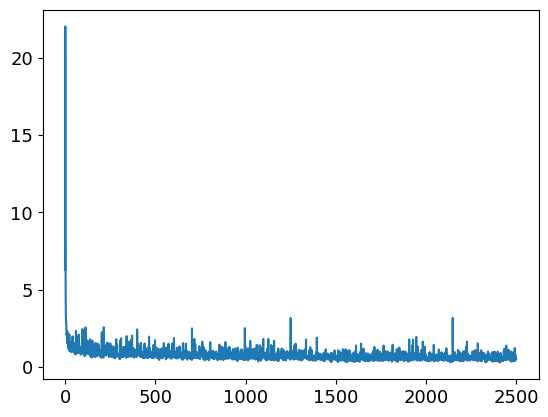

In [ ]:
plt.plot(losses['train'])

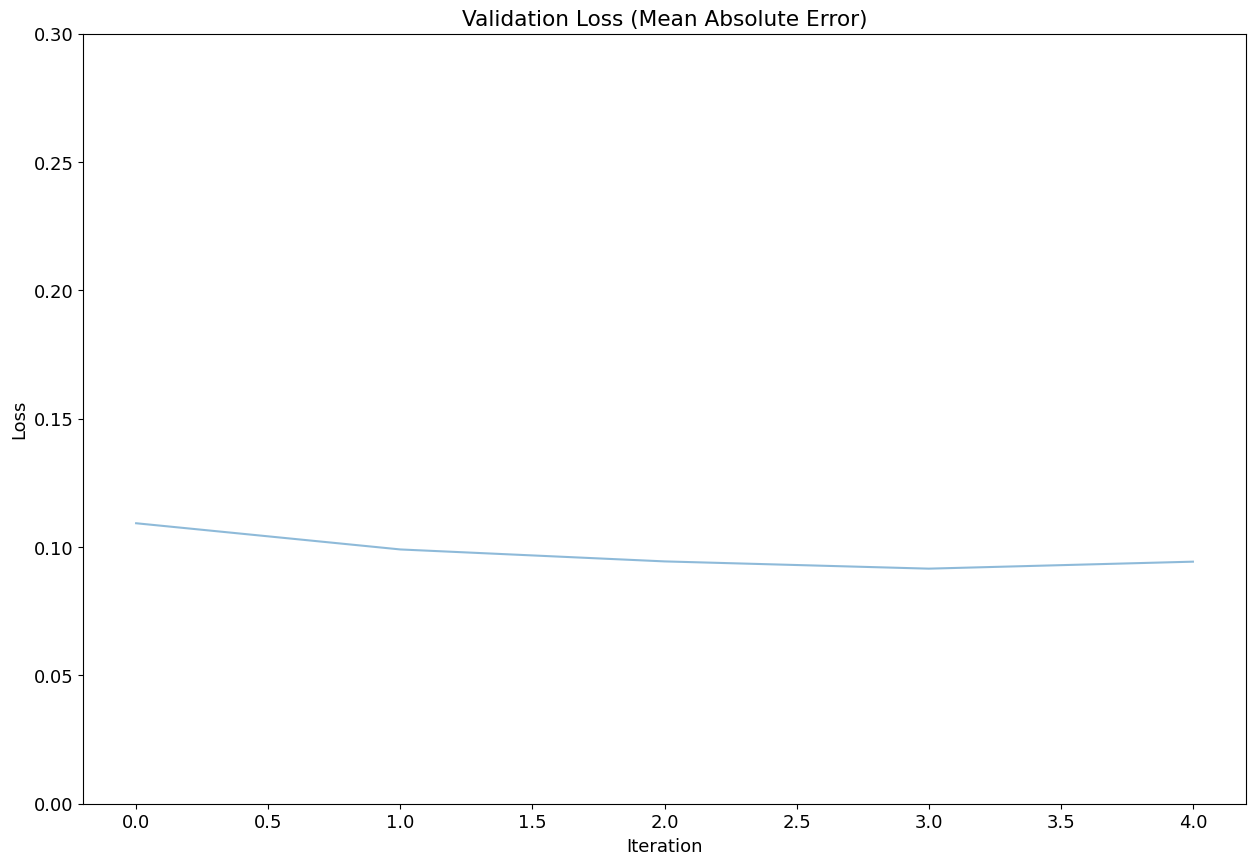

In [ ]:
fig = plt.figure(figsize=(15,10))
y = losses['valid']
N = len(y)

K = 25
avg = []
for i in range(K, N-K):
  avg.append(sum(y[(i-K):(i+K+1)])/(2*K+1))
  
plt.plot(range(N), y, alpha=0.5)
plt.plot(range(K, N-K), avg, 'maroon')
plt.ylim(0, 0.3)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Validation Loss (Mean Absolute Error)')
#plt.show()
plt.savefig('val_loss.png')

In [ ]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=True, num_workers=workers)

test_loss = 0.
model.eval()
with torch.no_grad():
  for i in range(len(test_dataloader)):
    input, target = next(iter(test_dataloader))
    out = model(input.cuda())[-1]
    test_loss += MAE(out, target.cuda()).item() / len(test_dataloader)

print(test_loss)
     


In [ ]:
model_name = 'u2net-celebamask'

loss_path = F"{model_saved_dir}/{model_name}_loss.txt"
model_path = F"{model_saved_dir}/{model_name}.pt"

with open(loss_path, 'rb') as f:
  losses = pickle.load(f)

# model.load_state_dict(torch.load(model_path))

## Synthesize GIF

In [ ]:
import cv2


def GifToFrame(path, size=256): 
    frames, masks = [], []
    gif = cv2.VideoCapture(gif_path)
    fps = gif.get(cv2.CAP_PROP_FPS)
    
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.CenterCrop(size),
                                    transforms.Resize(256),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    while True:
      ret, frame = gif.read()
      if ret:             
        frames.append(transform(frame))
            
      else:
        break
    
    print("GIF Info: %dx%d, %d frames, %d fps" % 
          (frames[0].shape[1], frames[0].shape[2], len(frames), fps))
    
    return frames, fps
     

import imageio
import math

n_input = 16
sizes = [604, 594, 542, 524, 507, 664]

total_combs = []

for idx, size in enumerate(sizes):
  gif_path = "karina{}.gif".format(idx+1)

  resize, fps = GifToFrame(gif_path, size=size)
  plt.imshow(ImgForPlot(resize[0]))
  plt.show()

  # Change frames with generator
  N = math.ceil(len(resize) / n_input)
  outputs = []
  with torch.no_grad():
    for t in range(N):
      s = t * n_input
      e = min((t+1) * n_input, len(resize))
      inputs = torch.stack(resize[s:e]).cuda()
      outputs.append(model(inputs)[-1])
  outputs = torch.cat(outputs)

  # Save Generated GIF
  outputs = [maskedImage(resize[k], outputs[k]) for k in range(len(outputs))]
  gen_path = gif_path.replace(".gif","-generated.gif")
  imageio.mimsave(gen_path, outputs, format='GIF', fps=fps)
  print("Save generated gif completely.")

  combs = []
  for i in range(len(outputs)):
      comb = np.ndarray((256,512,3), dtype=np.uint8)
      comb[:, 0:256] = ImgForPlot(resize[i])
      comb[:, 256:512] = outputs[i]
      combs.append(comb)
  total_combs.append(combs)

  comb_path = gif_path.replace(".gif","-combined.gif")
  imageio.mimsave(comb_path, combs, format='GIF', fps=fps)
  print("Save combined gif completely.")
     
